<a href="https://colab.research.google.com/github/ankygupta9999/DL-image-captioning/blob/main/DL_Assignment2_AG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import pickle
import os, re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.applications import efficientnet, resnet50
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.models import Model

#Random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

FILE_PATH = "/content/gdrive/MyDrive/Datasets"
IMAGE_DATA_PATH = "/content/gdrive/MyDrive/Datasets/Image_captioning_Dataset.zip"
CAPTIONS_PATH = os.path.join(FILE_PATH, "set_1.pkl")

In [3]:
# Download the dataset
# !unzip -q IMAGE_DATA_PATH
import zipfile

with zipfile.ZipFile(IMAGE_DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(os.curdir)

In [4]:
IMAGE_DATA_FOLDER = "Flicker8k_Dataset/"

In [5]:
# Printing sample data
objects = pd.read_pickle(CAPTIONS_PATH)
df = pd.DataFrame(objects)
print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
                                                       0
0      2089122314_40d5739aef.jpg#3\tA fluffy , tri-co...
1      1295671216_cde1b9c9d1.jpg#0\tA crowd of person...
2      3183195185_cd0ff994a1.jpg#4\tThe man and boy s...
3      2949353587_64c54e9589.jpg#1\tA brown dog be pl...
4      361092202_3d70144ebd.jpg#2\tA man hike with a ...
...                                                  ...
24995  3503623999_bbd5dcfb18.jpg#0\tA man in a crowd ...
24996  542405691_0594b1ce72.jpg#0\tA boy kick a ball ...
24997  1244485675_822e6efe60.jpg#1\tA boy look at his...
24998  475778645_65b7343c47.jpg#4\tA small child clim...
24999  381052465_722e00807b.jpg#4\tPeople put out a f...

[25000 rows x 1 columns]


In [6]:
# Converting to a dataframe
raw_df = pd.DataFrame()
for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  # img_dict['caption_id'] = row.split(img_dict['img_nm'])[1].split('\t')[0]
  img_dict['caption_id'] = str(row).split('#')[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)
raw_df.head()

,caption_id,img_caption,img_nm
0,3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [7]:
# raw_df[raw_df.img_nm == '2258277193_586949ec62.jpg.1']['img_nm'] = '2258277193_586949ec62.jpg'
raw_df.drop(raw_df[raw_df.img_nm == '2258277193_586949ec62.jpg.1'].index, inplace=True)

In [8]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24996 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   24996 non-null  object
 1   img_caption  24996 non-null  object
 2   img_nm       24996 non-null  object
dtypes: object(3)
memory usage: 781.1+ KB


In [9]:
print(len(raw_df.img_nm.unique()))
print(len(os.listdir(IMAGE_DATA_FOLDER)))

8032
8091


In [10]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [11]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      just_img_nm = img_nm.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" +caption, loc='left')
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

**Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

============== Printing Sample images ================


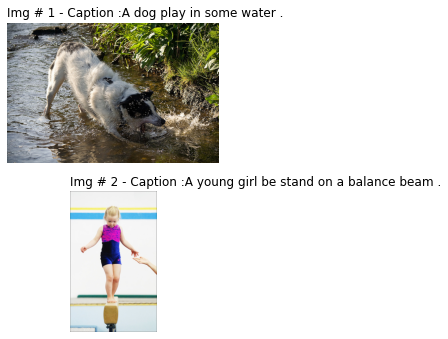

In [12]:
print_sample_imgs(IMAGE_DATA_FOLDER, os.listdir(IMAGE_DATA_FOLDER), nrows=5, ncols=1, nimages=2, df=raw_df)

**Data Preparation**

**Model Building**

In [13]:
# extrat Features
def extract_features(directory):
    
    model = ResNet50()
    
    #remove last layer
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    print(model.summary())
    
    features = dict()
    
    for i, name in enumerate(os.listdir(directory)):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))
        
        image = img_to_array(image)
        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))
        
        image = preprocess_input(image)
        
        feature = model.predict(image , verbose = 0)
        
        # get image id
        if (name == '2258277193_586949ec62.jpg.1'):
          print(i, name)
          print ('fixing strange image id :',name, name.split(".")[0])
          image_id = '2258277193_586949ec62'
        else:
          image_id = name.split(".")[0]
        
        # store features
        features[image_id] = feature
        
        # print(i, name)
        
    return features

In [16]:
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('extracted features :',len(features))
pickle.dump(features , open('features.pkl' , 'wb'))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________
None
extracted features : 8091


Create Vocabulary from Images

In [17]:
lemma = WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
        image_id = doc['img_nm'][i]
        image_desc = doc['img_caption'][i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

In [18]:
# convert loaded descriptions into vocablury
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()

In [19]:
raw_df.head()

,caption_id,img_caption,img_nm
0,3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [20]:
raw_df['caption_id'] = raw_df['caption_id'].apply(lambda x : x.lstrip('#'))

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
raw_df['img_caption'] = raw_df['img_caption'].apply(lambda x : clean_text(str(x)))

In [23]:
raw_df.reset_index(drop=True, inplace=True)

In [24]:
img_caption_map = load_decriptions(raw_df)

In [25]:
vocabulary = to_vocabluary(img_caption_map)

In [26]:
len(vocabulary)

5387

In [27]:
save_descriptions(img_caption_map , 'descriptions.txt')

Train set

In [28]:
from pickle import load


In [29]:
# loading the doc
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# this function is used for to get train image description from our dataset

def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # we add two tage at start and at end of the descitpion to identify to start and 
            # end of desc.
            desc = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions


# laod photo features
def load_photo_features(filename , dataset):
    all_features = pickle.load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    # features={}
    # for k in dataset:
      # if k in all_features.keys():
        # features[k+'.jpg'] = all_features[k]
      # else:
        # pass
    return features

In [30]:
raw_df.columns

Index(['caption_id', 'img_caption', 'img_nm'], dtype='object')

In [31]:
len(raw_df.img_nm)

24996

In [32]:
train = set(raw_df['img_nm'][:10000])
print('len of train image',len(train))

len of train image 6146


In [33]:
# training set making and set startseq and endseq tag in descriptions
train_descriptions = load_clean_descriptions('descriptions.txt' , train)

In [34]:
print('len of train descriptions' , len(train_descriptions))

len of train descriptions 6146


In [35]:
train = pd.DataFrame(train)

In [36]:
train2 = train[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [37]:
# train features means feautures from training images
train_features = load_photo_features('features.pkl' , train2)
print('photos train :',len(train_features))

photos train : 6146


In [38]:
# convert dictonary to list descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

# fit tokenizer on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [39]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size' , vocab_size)

vocab size 4919


In [40]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [41]:
# calculate the length with most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(line.split())for line in lines])
    
# create sequences of images,input sequences and output sequences
def create_sequences(tokenizer , max_length , desc_list , photo):
    X1 , X2 , y = list() , list() , list()
    
    for desc in desc_list:
        # convert words to number value
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            
            in_seq , output_seq = seq[:i] , seq[i]
            in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
            output_seq = to_categorical([output_seq] , num_classes = vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(output_seq)
            
    return np.array(X1) , np.array(X2) , np.array(y)

In [42]:
from keras.models import Model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout
from keras.layers.merge import add
from keras.callbacks import EarlyStopping

In [43]:
def define_Model(vocab_size , max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(1000 , ))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)
    fe4 = Dense(128 , activation = 'relu')(fe3)
    fe5 = Dense(64 , activation = 'relu')(fe4)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,512,mask_zero=True )(inputs2) # mask_zero = ignore padding
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(512 , return_sequences=True)(se2)
    se4 = Dropout(0.4)(se3)
    se5 = LSTM(256, return_sequences=True)(se4)
    se6 = Dropout(0.4)(se5)
    se7 = LSTM(128, return_sequences=True)(se6)
    se8 = Dropout(0.4)(se7)
    se9 = LSTM(64)(se8)
    
    
    #decoder Model
    decoder1 = add([fe5 , se9])
    decoder2 = Dense(128 , activation='relu')(decoder1)
    decoder3 = Dense(256 , activation='relu')(decoder2)
    decoder4 = Dense(512 , activation='relu')(decoder3)
    outputs = Dense(vocab_size , activation='softmax')(decoder4)
    
    # combine both image and text
    model = Model([inputs1 , inputs2] , outputs)
    model.compile(loss='categorical_crossentropy' , optimizer = 'adam')
    
    # summary
    print(model.summary())
    
    return model

In [44]:
# below code progressivly load the code in batches
def data_generator(descriptions , photos , tokenizer , max_length):
    while 1:
        for key , desc_list in descriptions.items():
            photo = photos[key][0]
            in_img , in_seq , out_seq = create_sequences(tokenizer , max_length , desc_list , photo)
            in_final_seq = [in_img , in_seq]
            yield (in_final_seq, out_seq)

In [45]:
# train_descriptions.pop('2258277193_586949ec62.jpg.1')

In [46]:
print('len :', len(train))
print('Descriptions :',len(train_descriptions))
print('photos train :',len(train_features))
print('Vocabulary size :',vocab_size)
max_len = max_length(train_descriptions)
print('Description max length :', max_len)

len : 6146
Descriptions : 6146
photos train : 6146
Vocabulary size : 4919
Description max length : 34


In [47]:
from keras.models import load_model

In [48]:
model = define_Model(vocab_size , max_len)
epochs = 5
steps = len(train_descriptions)

for i in range(epochs):
    generator = data_generator(train_descriptions , train_features , tokenizer , max_len)
    # model.fit_generator()
    model.fit_generator(generator , epochs = 1 , steps_per_epoch = steps , verbose = 1)
    
    model.save('model_'+ str(i+1) + '.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 512)      2518528     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 34, 512)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 34, 512)      2099200     dropout_1[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6146/6146 [==============================] - 2389s 385ms/step - loss: 4.7390


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6146/6146 [==============================] - 2295s 373ms/step - loss: 3.2436


Bleu Score For Model Evalution

In [49]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word

In [50]:
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [51]:
from nltk.translate.bleu_score import corpus_bleu

In [52]:
def evaluate_model(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        generated_desc = generate_desc(model , tokenizer , photos[key] , max_length)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(generated_desc.split())
    
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    
    print('Bleu_Score -2 = %f'%corpus_bleu(actual , predicted , weights=(0.5,0.5,0,0)))
    
    print('Bleu_Score -3 = %f'%corpus_bleu(actual , predicted , weights=(0.33,0.33,0.33,0))) 
    
    print('Bleu_Score -4 = %f'%corpus_bleu(actual , predicted , weights=(0.25,0.25,0.25,0.25)))

**Model Predicting**

In [54]:
test = set(descriptions['image_id'][10001:])
test_descriptions = load_clean_descriptions('descriptions.txt',test)
test = pd.DataFrame(test)
test2 = test[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

NameError: ignored

In [ ]:
test_features = load_photo_features('features.pkl',test2)

In [ ]:
from keras.models import load_model
filename = 'model_11.h5'
model = load_model(filename)

In [ ]:
print('len of test dataset',len(test))
print('len of Descriptions',len(test_descriptions))
print('len of Test features',len(test_features))

In [ ]:
evaluate_model(model , test_descriptions , test_features , tokenizer , max_len)
pickle.dump(tokenizer , open('tokenizer.pkl','wb'))

In [ ]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
        
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [ ]:
def extract_features_for_one_image(filename):
    model = ResNet50()
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    image = load_img(filename , target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    return feature

In [ ]:
def get_image_caption(filename,model):
    tokenizer = load(open('tokenizer.pkl','rb'))
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo , 80)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [ ]:
model2 = load_model('model_11.h5')


In [ ]:
from IPython.display import Image,display
filename = 'test_image.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))

In [ ]:

filename = 'test_image2.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))